# 타이타닉 생존자 예측 - Pro_5 (No Data Leakage + WCG)

## 🎯 Pro_5 핵심 전략
1. **Target Leakage 완전 방지**: sklearn Pipeline 내부에서 Preprocessor 적용
2. **KNN Imputer**: Age, Fare, Embarked 결측치 처리
3. **WCG 전략**: 가족 내 여성+아이 생존 → Master도 생존
4. **RepeatedStratifiedKFold**: n_repeats=10으로 안정적인 CV
5. **과적합 자동 조정**: check_overfitting_with_feedback 함수
6. **StandardScaler**: SVC, KNN, MLP, LogisticRegression에만 적용
7. **VIF 검증**: 다중공선성 피처 제거 후 검증

In [1]:
# ============================================================
# 1. 라이브러리 임포트
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Visualization settings
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# ------------------------------------------------------------
# Korean Font Settings
# ------------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    print('🪟 Windows: Malgun Gothic 설정')
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin': 
    print('🍎 Mac: AppleGothic 설정')
    plt.rc('font', family='AppleGothic')
elif 'google.colab' in sys.modules:
    print('☁️ Colab: NanumBarunGothic 설치 및 설정')
    !apt-get update -qq
    !apt-get install fonts-nanum* -qq
    import matplotlib.font_manager as fm
    fe = fm.FontEntry(
        fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
        name='NanumBarunGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rc('font', family=fe.name)
else:
    # Linux / Kaggle / Other
    print('🐧 Linux/Other: NanumGothic 설정')
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

print('✅ 라이브러리 임포트 및 한글 폰트 설정 완료')

🪟 Windows: Malgun Gothic 설정
✅ 라이브러리 임포트 및 한글 폰트 설정 완료


c:\Users\user\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================
# 2. 데이터 불러오기
# ============================================================
base_path = r'C:/Users/user/github/DataScience/scikit-learn/scikit-learn/data/titanic'
train_df = pd.read_csv(f'{base_path}/train.csv')
test_df = pd.read_csv(f'{base_path}/test.csv')

test_passenger_ids = test_df['PassengerId'].copy()
train_len = len(train_df)
all_data = pd.concat([train_df, test_df], ignore_index=True)

print(f'Train: {train_df.shape}, Test: {test_df.shape}, All: {all_data.shape}')

Train: (891, 12), Test: (418, 11), All: (1309, 12)


In [3]:
# ============================================================
# 3. KNN Imputer for Age, Fare, Embarked
# ============================================================

def find_best_k_neighbors(train_df):
    print('🔍 KNN Imputer n_neighbors 최적화 중...')
    results = []
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    
    for k in range(3, 12, 2):
        df = train_df.copy()
        df['Sex_num'] = (df['Sex'] == 'male').astype(int)
        df['Embarked_num'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).fillna(-1)
        
        imputer_cols = ['Pclass', 'Sex_num', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']
        imputer = KNNImputer(n_neighbors=k)
        df_imputed = pd.DataFrame(imputer.fit_transform(df[imputer_cols]), columns=imputer_cols)
        df['Age'] = df_imputed['Age']
        df['Fare'] = df_imputed['Fare']
        df['Embarked_num'] = df_imputed['Embarked_num'].round().astype(int)
        
        X = df[['Pclass', 'Sex_num', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']]
        y = df['Survived'].astype(int)
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        results.append({'k': k, 'cv_accuracy': scores.mean()})
        print(f'  k={k}: CV Accuracy = {scores.mean():.4f}')
    
    results_df = pd.DataFrame(results)
    best_k = results_df.loc[results_df['cv_accuracy'].idxmax(), 'k']
    print(f'\n🏆 최적 n_neighbors = {best_k}')
    return int(best_k)

best_k = find_best_k_neighbors(train_df)

🔍 KNN Imputer n_neighbors 최적화 중...
  k=3: CV Accuracy = 0.8202
  k=5: CV Accuracy = 0.8211
  k=7: CV Accuracy = 0.8242
  k=9: CV Accuracy = 0.8215
  k=11: CV Accuracy = 0.8202

🏆 최적 n_neighbors = 7


In [4]:
# ============================================================
# 4. WCG (Women, Children, Group) 전략 + KNN Imputer 적용
# ============================================================

def add_wcg_family_survival(all_data, train_len, best_k):
    all_data = all_data.copy()
    
    # Basic features
    all_data['Last_Name'] = all_data['Name'].apply(lambda x: x.split(',')[0])
    all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    all_data['TicketFrequency'] = all_data['Ticket'].map(all_data['Ticket'].value_counts())
    all_data['Sex_num'] = (all_data['Sex'] == 'male').astype(int)
    all_data['Embarked_num'] = all_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # KNN Imputer for Age, Fare, Embarked
    print(f'🔧 KNN Imputer 적용 (n_neighbors={best_k})...')
    imputer_cols = ['Pclass', 'Sex_num', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']
    imputer = KNNImputer(n_neighbors=best_k)
    df_imputed = pd.DataFrame(imputer.fit_transform(all_data[imputer_cols]), columns=imputer_cols, index=all_data.index)
    all_data['Age'] = df_imputed['Age']
    all_data['Fare'] = df_imputed['Fare']
    all_data['Embarked_num'] = df_imputed['Embarked_num'].round().astype(int)
    
    # Fare per person
    all_data['Fare_Per_Person'] = all_data['Fare'] / all_data['TicketFrequency']
    all_data['Fare_Per_Person_Round'] = all_data['Fare_Per_Person'].round(2)
    
    # Gender/Age flags
    all_data['IsChild'] = (all_data['Age'] < 10).astype(int)
    all_data['IsFemale'] = (all_data['Sex'] == 'female').astype(int)
    all_data['IsMaster'] = (all_data['Title'] == 'Master').astype(int)
    all_data['IsMaleChild'] = ((all_data['Sex'] == 'male') & (all_data['IsChild'] == 1)).astype(int)
    
    # Family Survival
    all_data['Family_Survival'] = 0.5
    all_data['WCG_Survival'] = 0
    
    print('📊 Family_Survival 계산 중...')
    for ticket, grp_df in all_data.groupby('Ticket'):
        if len(grp_df) > 1:
            for idx in grp_df.index:
                others = grp_df.drop(idx)
                others_train = others[others.index < train_len]
                if len(others_train) > 0:
                    if others_train['Survived'].max() == 1.0:
                        all_data.loc[idx, 'Family_Survival'] = 1
                    elif others_train['Survived'].min() == 0.0:
                        all_data.loc[idx, 'Family_Survival'] = 0
    
    for (last_name, fare_pp, embarked), grp_df in all_data.groupby(['Last_Name', 'Fare_Per_Person_Round', 'Embarked_num']):
        if len(grp_df) > 1:
            for idx in grp_df.index:
                if all_data.loc[idx, 'Family_Survival'] == 0.5:
                    others = grp_df.drop(idx)
                    others_train = others[others.index < train_len]
                    if len(others_train) > 0:
                        if others_train['Survived'].max() == 1.0:
                            all_data.loc[idx, 'Family_Survival'] = 1
                        elif others_train['Survived'].min() == 0.0:
                            all_data.loc[idx, 'Family_Survival'] = 0
    
    print('🎯 WCG 전략 적용 중...')
    for ticket, grp_df in all_data.groupby('Ticket'):
        if len(grp_df) > 1:
            grp_train = grp_df[grp_df.index < train_len]
            if len(grp_train) > 0:
                women_children = grp_train[(grp_train['IsFemale'] == 1) | (grp_train['IsChild'] == 1)]
                if len(women_children) > 0 and (women_children['Survived'] == 1).all():
                    for idx in grp_df.index:
                        if all_data.loc[idx, 'IsMaster'] == 1 or all_data.loc[idx, 'IsMaleChild'] == 1:
                            all_data.loc[idx, 'WCG_Survival'] = 1
                            all_data.loc[idx, 'Family_Survival'] = 1
    
    print(f'✅ Family_Survival 분포: {all_data["Family_Survival"].value_counts().to_dict()}')
    return all_data

all_data = add_wcg_family_survival(all_data, train_len, best_k)
print('\n✅ KNN Imputer + WCG 특성 생성 완료')

🔧 KNN Imputer 적용 (n_neighbors=7)...
📊 Family_Survival 계산 중...
🎯 WCG 전략 적용 중...
✅ Family_Survival 분포: {0.5: 754, 1.0: 309, 0.0: 246}

✅ KNN Imputer + WCG 특성 생성 완료


In [5]:
# ============================================================
# 5. Feature Engineering
# ============================================================

def preprocessing_pro5(all_data):
    all_data = all_data.copy()
    
    title_mapping = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 'Capt': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Rare', 'Countess': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Jonkheer': 'Rare'}
    all_data['Title'] = all_data['Title'].map(title_mapping).fillna('Rare')
    all_data['Sex'] = (all_data['Sex'] == 'male').astype(int)
    all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
    all_data['IsAlone'] = (all_data['FamilySize'] == 1).astype(int)
    
    def age_to_bin(age):
        if pd.isna(age): return 2
        elif age < 10: return 0
        elif age < 18: return 1
        elif age < 35: return 2
        elif age < 50: return 3
        else: return 4
    all_data['AgeBin'] = all_data['Age'].apply(age_to_bin).astype(int)
    all_data['LogFare'] = np.log1p(all_data['Fare_Per_Person'])
    all_data['Deck'] = all_data['Cabin'].str[0].fillna('U')
    deck_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 0, 'U': 0}
    all_data['Deck'] = all_data['Deck'].map(deck_map).fillna(0).astype(int)
    title_enc = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    all_data['Title'] = all_data['Title'].map(title_enc).fillna(4).astype(int)
    all_data['Sex_Pclass'] = all_data['Sex'] * all_data['Pclass']
    
    return all_data

all_data = preprocessing_pro5(all_data)
print('✅ Feature Engineering 완료')

✅ Feature Engineering 완료


In [6]:
# ============================================================
# 6. 데이터 분리
# ============================================================

features = ['Pclass', 'Sex', 'LogFare', 'Embarked_num', 'Title', 'FamilySize', 'IsChild', 
            'Family_Survival', 'TicketFrequency', 'Deck', 'AgeBin', 'Sex_Pclass']

train_processed = all_data.iloc[:train_len].copy()
test_processed = all_data.iloc[train_len:].copy()

X = train_processed[features]
y = train_processed['Survived'].astype(int)
X_test = test_processed[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_optuna = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')
print(f'CV: RepeatedStratifiedKFold(n_splits=5, n_repeats=10) → 총 50회')
print(f'✅ StandardScaler fitted (for SVC, KNN, MLP, LogReg)')

Train: (757, 12), Validation: (134, 12), Test: (418, 12)
CV: RepeatedStratifiedKFold(n_splits=5, n_repeats=10) → 총 50회
✅ StandardScaler fitted (for SVC, KNN, MLP, LogReg)


# 7. 탐색적 데이터 분석 (EDA)

생존에 영향을 미치는 주요 요인들을 시각화합니다.

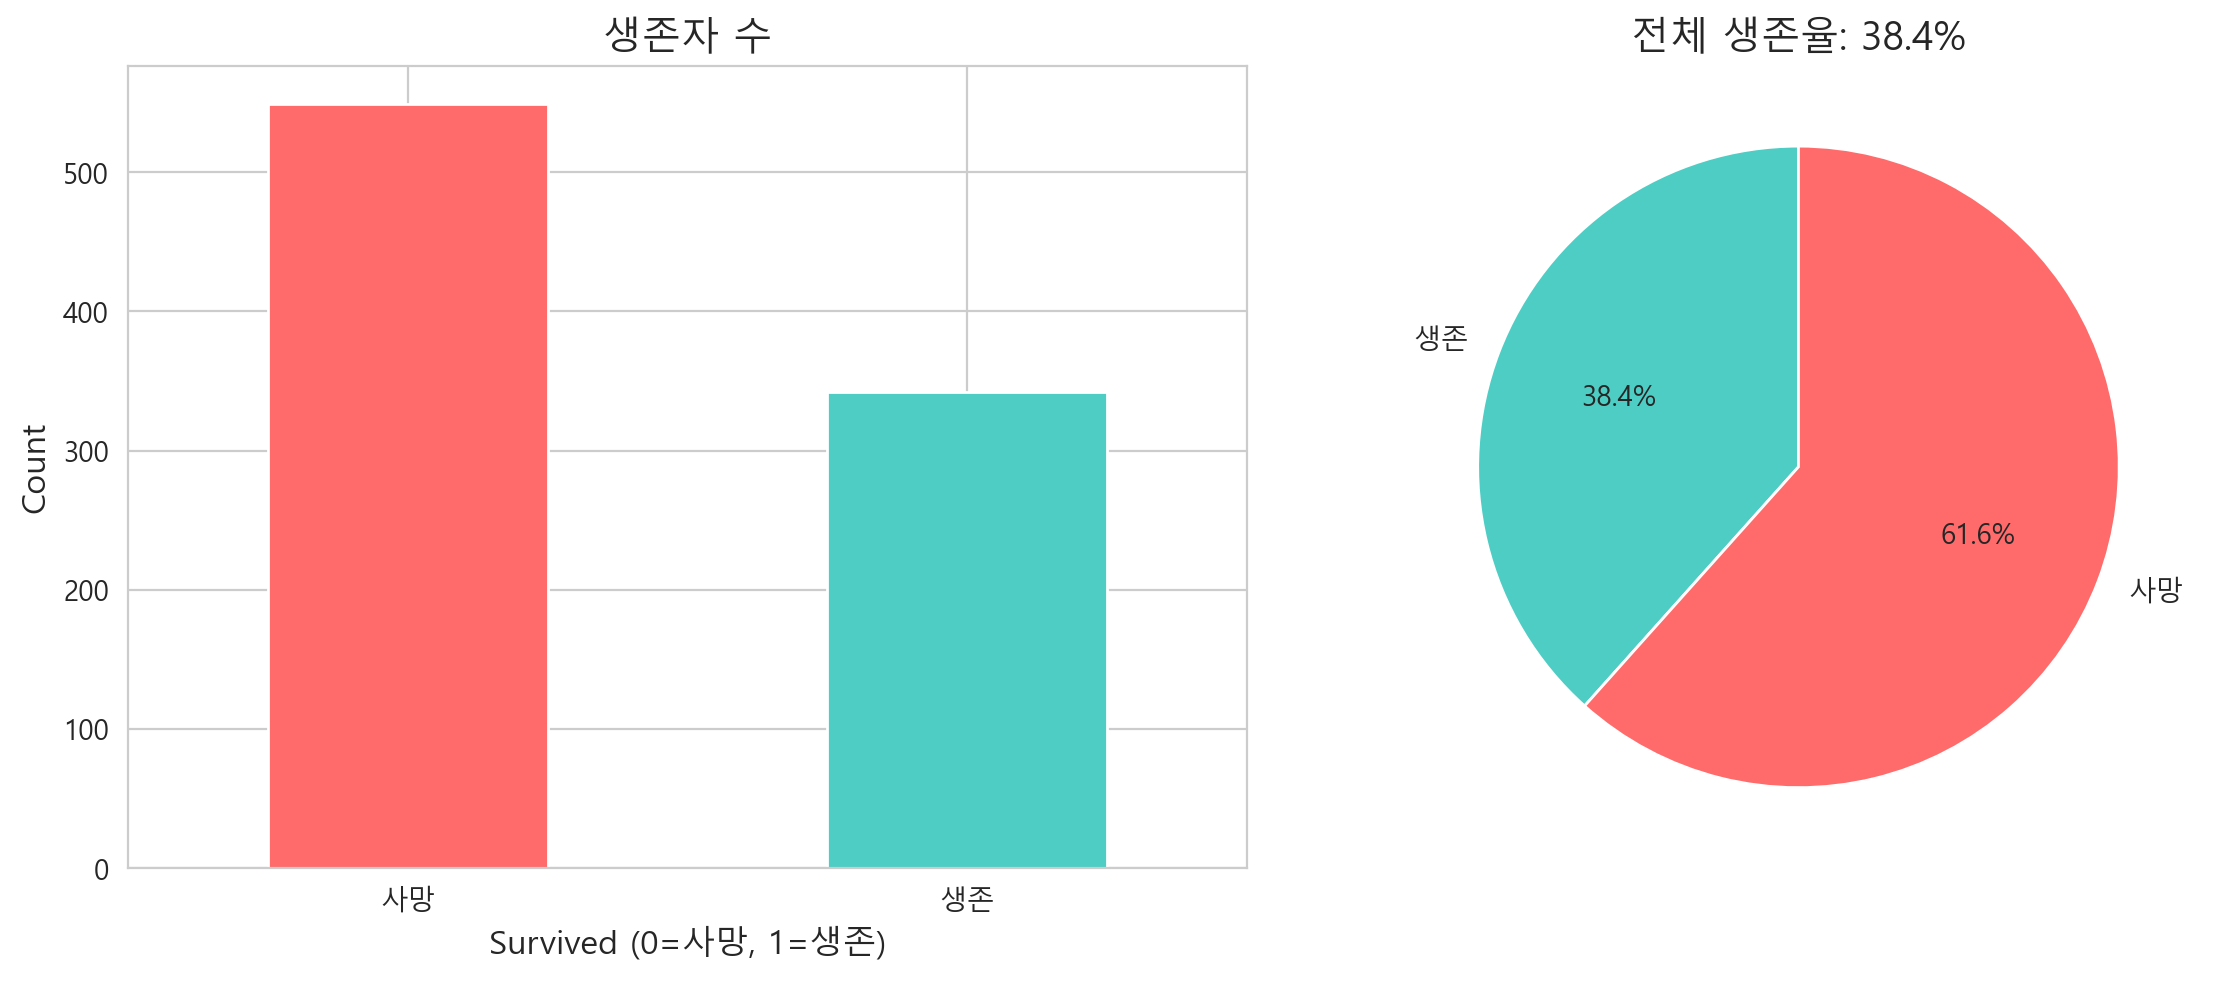

In [7]:
# ============================================================
# 7-1. 전체 생존율
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train_processed['Survived'].value_counts().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('생존자 수', fontsize=14)
axes[0].set_xlabel('Survived (0=사망, 1=생존)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['사망', '생존'], rotation=0)

survival_rate = train_processed['Survived'].mean() * 100
axes[1].pie([survival_rate, 100-survival_rate], labels=['생존', '사망'], 
            autopct='%1.1f%%', colors=['#4ecdc4', '#ff6b6b'], startangle=90)
axes[1].set_title(f'전체 생존율: {survival_rate:.1f}%', fontsize=14)
plt.tight_layout()
plt.show()

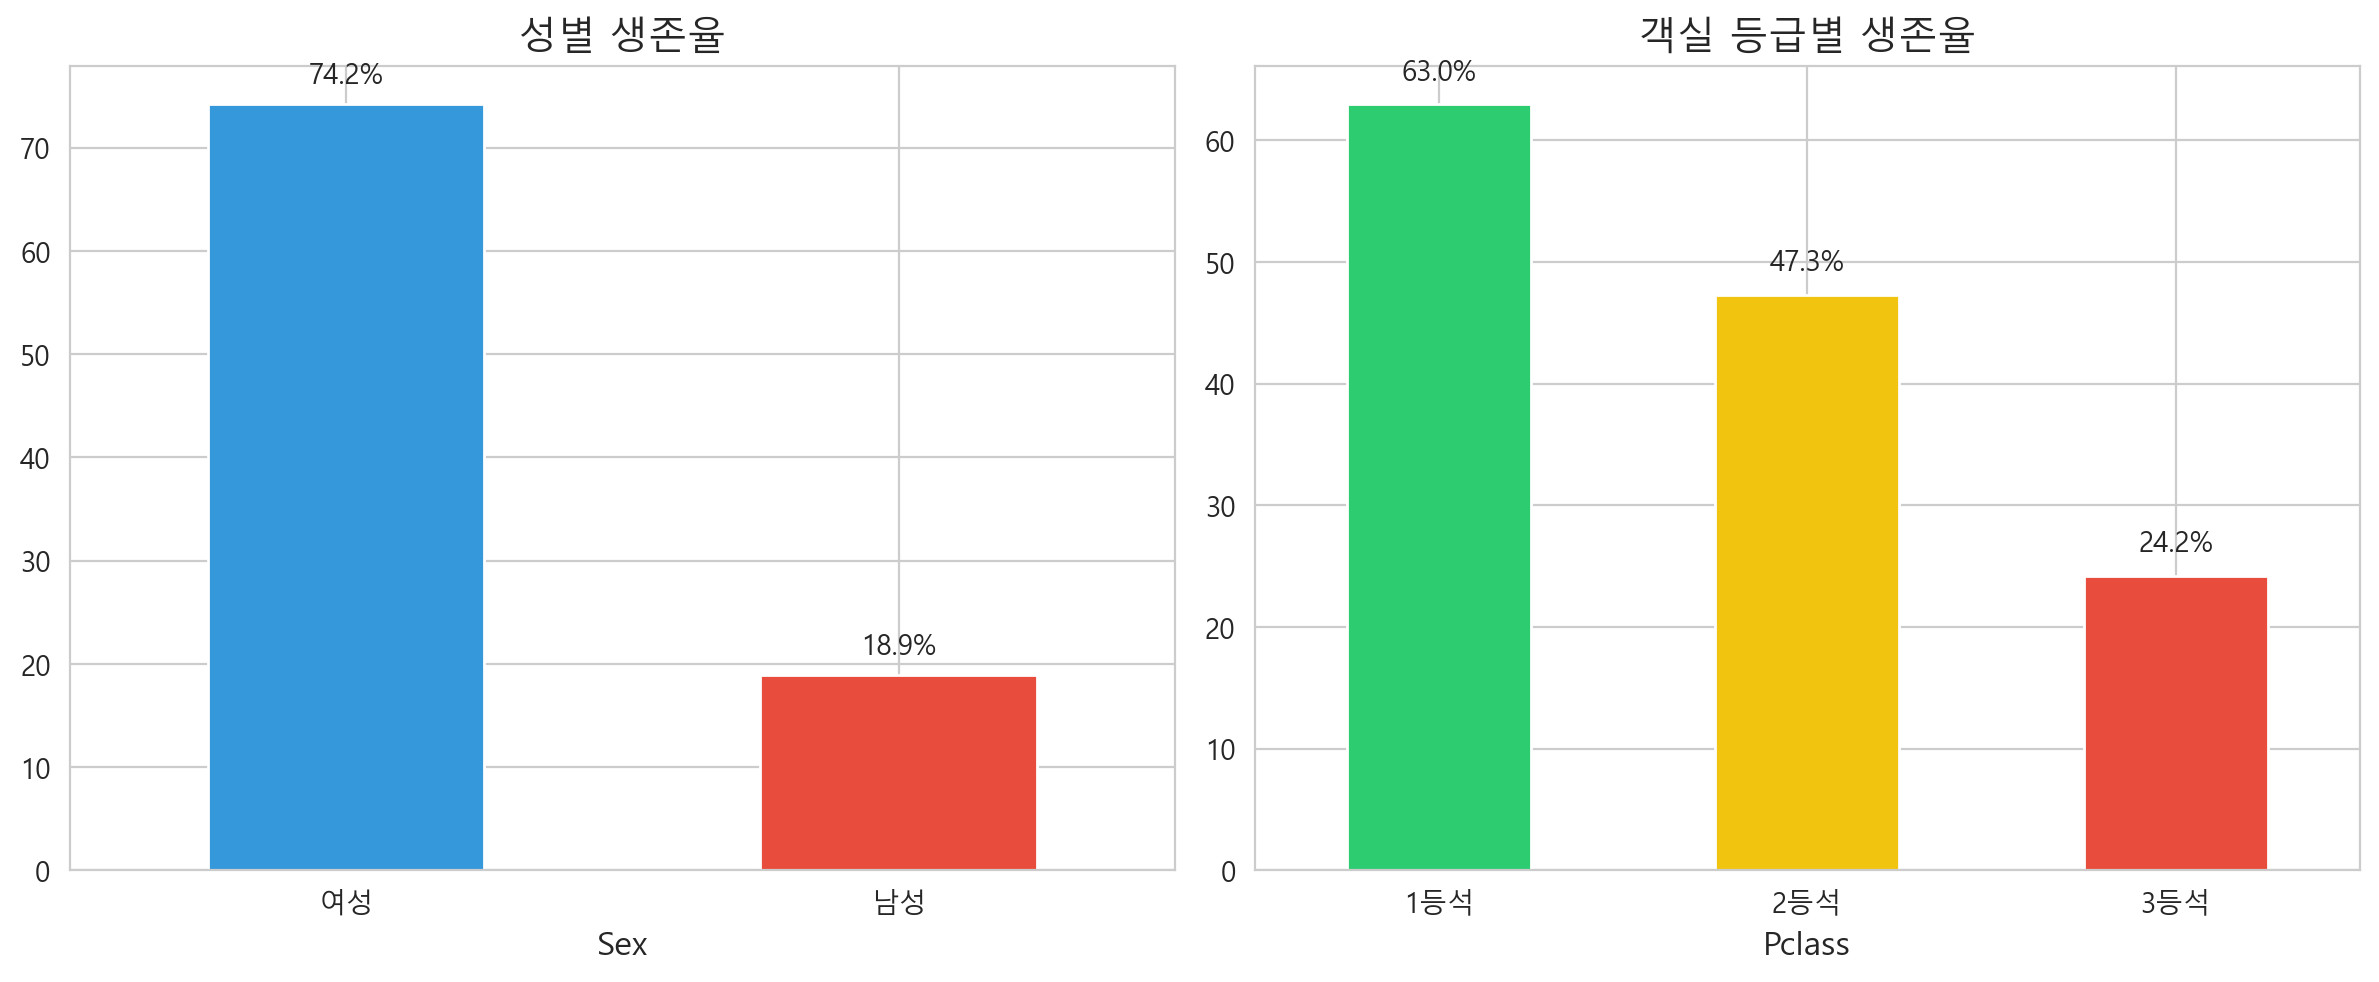

In [8]:
# ============================================================
# 7-2. 성별/등급별 생존율
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sex_survival = train_processed.groupby('Sex')['Survived'].mean() * 100
sex_survival.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('성별 생존율', fontsize=14)
axes[0].set_xticklabels(['여성', '남성'], rotation=0)
for i, v in enumerate(sex_survival): axes[0].text(i, v + 2, f'{v:.1f}%', ha='center')

pclass_survival = train_processed.groupby('Pclass')['Survived'].mean() * 100
pclass_survival.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#f1c40f', '#e74c3c'])
axes[1].set_title('객실 등급별 생존율', fontsize=14)
axes[1].set_xticklabels(['1등석', '2등석', '3등석'], rotation=0)
for i, v in enumerate(pclass_survival): axes[1].text(i, v + 2, f'{v:.1f}%', ha='center')
plt.tight_layout()
plt.show()

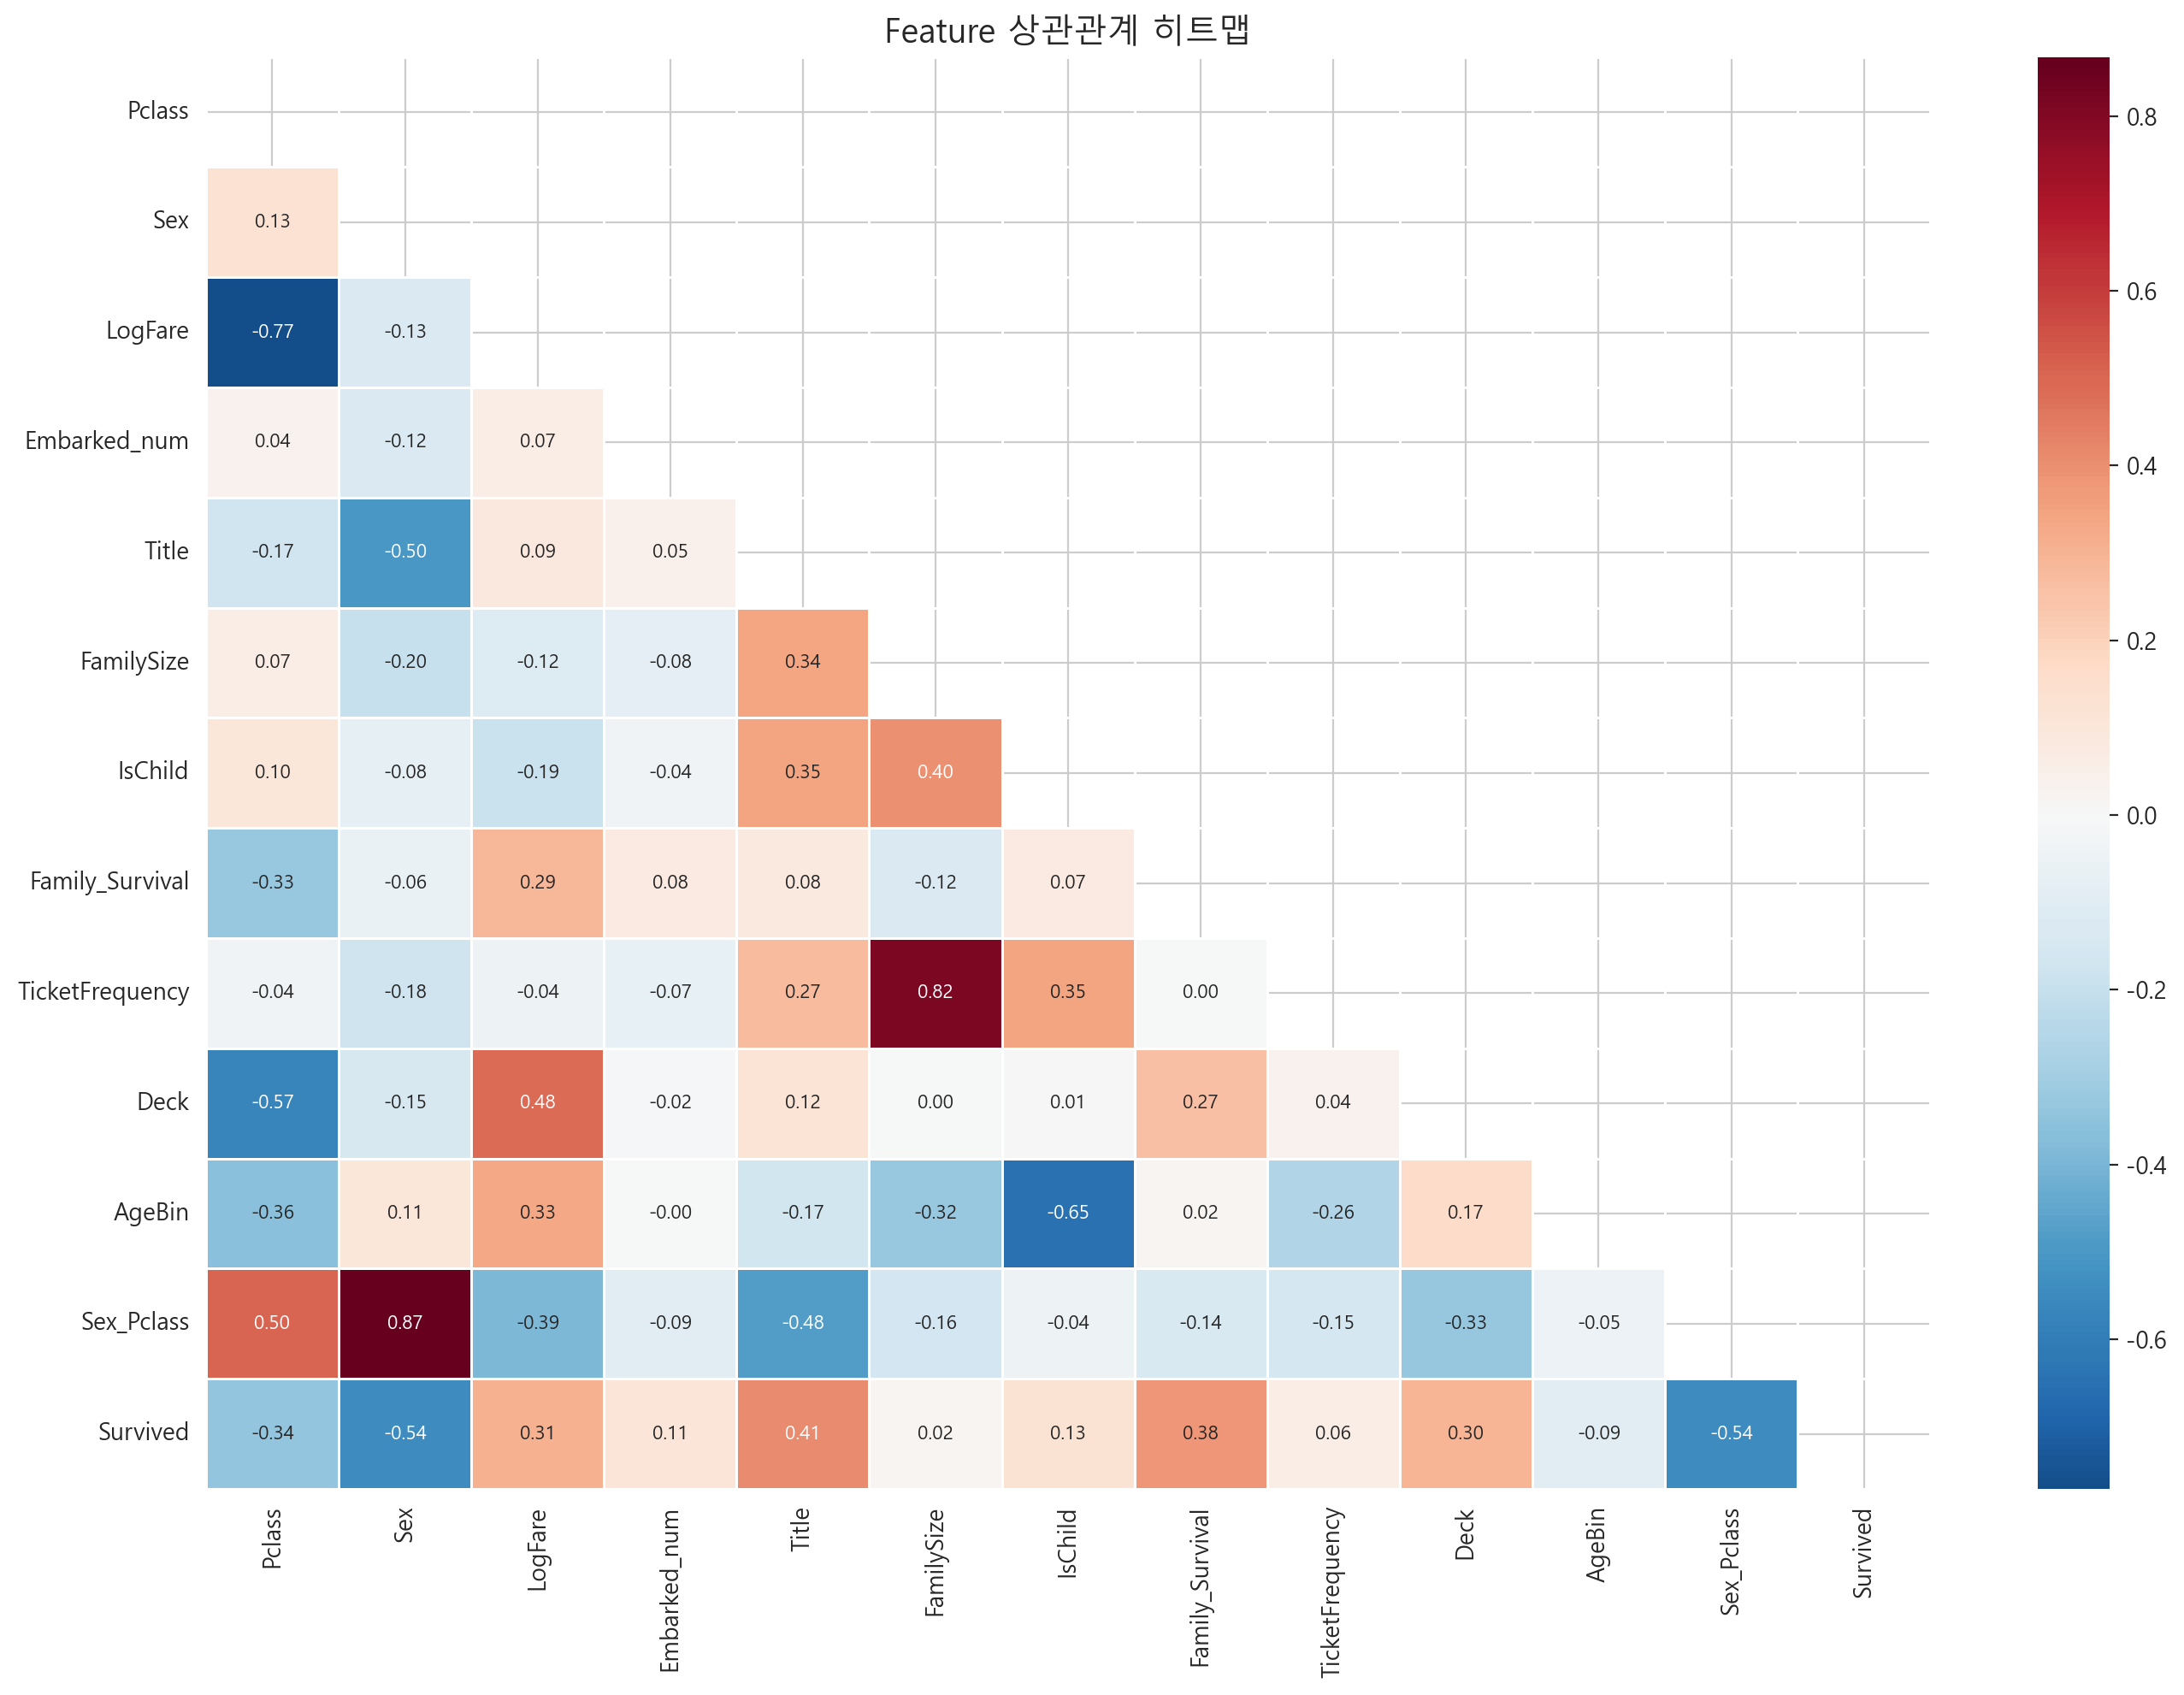

In [9]:
# ============================================================
# 7-3. 상관관계 히트맵
# ============================================================
plt.figure(figsize=(14, 10))
corr_matrix = train_processed[features + ['Survived']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, linewidths=0.5, annot_kws={'size': 8})
plt.title('Feature 상관관계 히트맵', fontsize=14)
plt.tight_layout()
plt.show()

📊 VIF (Variance Inflation Factor) 검증
   * 다중공선성 제거 후 남은 Feature들의 VIF 확인
   VIF > 10: 여전히 심각한 다중공선성 존재 가능성

        Feature       VIF Status
     Sex_Pclass 22.762509   🚨 주의
            Sex 21.164656   🚨 주의
        LogFare 14.644047   🚨 주의
         Pclass 12.416164   🚨 주의
         AgeBin 11.965896   🚨 주의
     FamilySize  8.409056  ⚠️ 경고
TicketFrequency  7.222467  ⚠️ 경고
Family_Survival  4.023337   ✅ 정상
          Title  2.519003   ✅ 정상
        IsChild  2.293613   ✅ 정상
           Deck  1.813675   ✅ 정상
   Embarked_num  1.388720   ✅ 정상


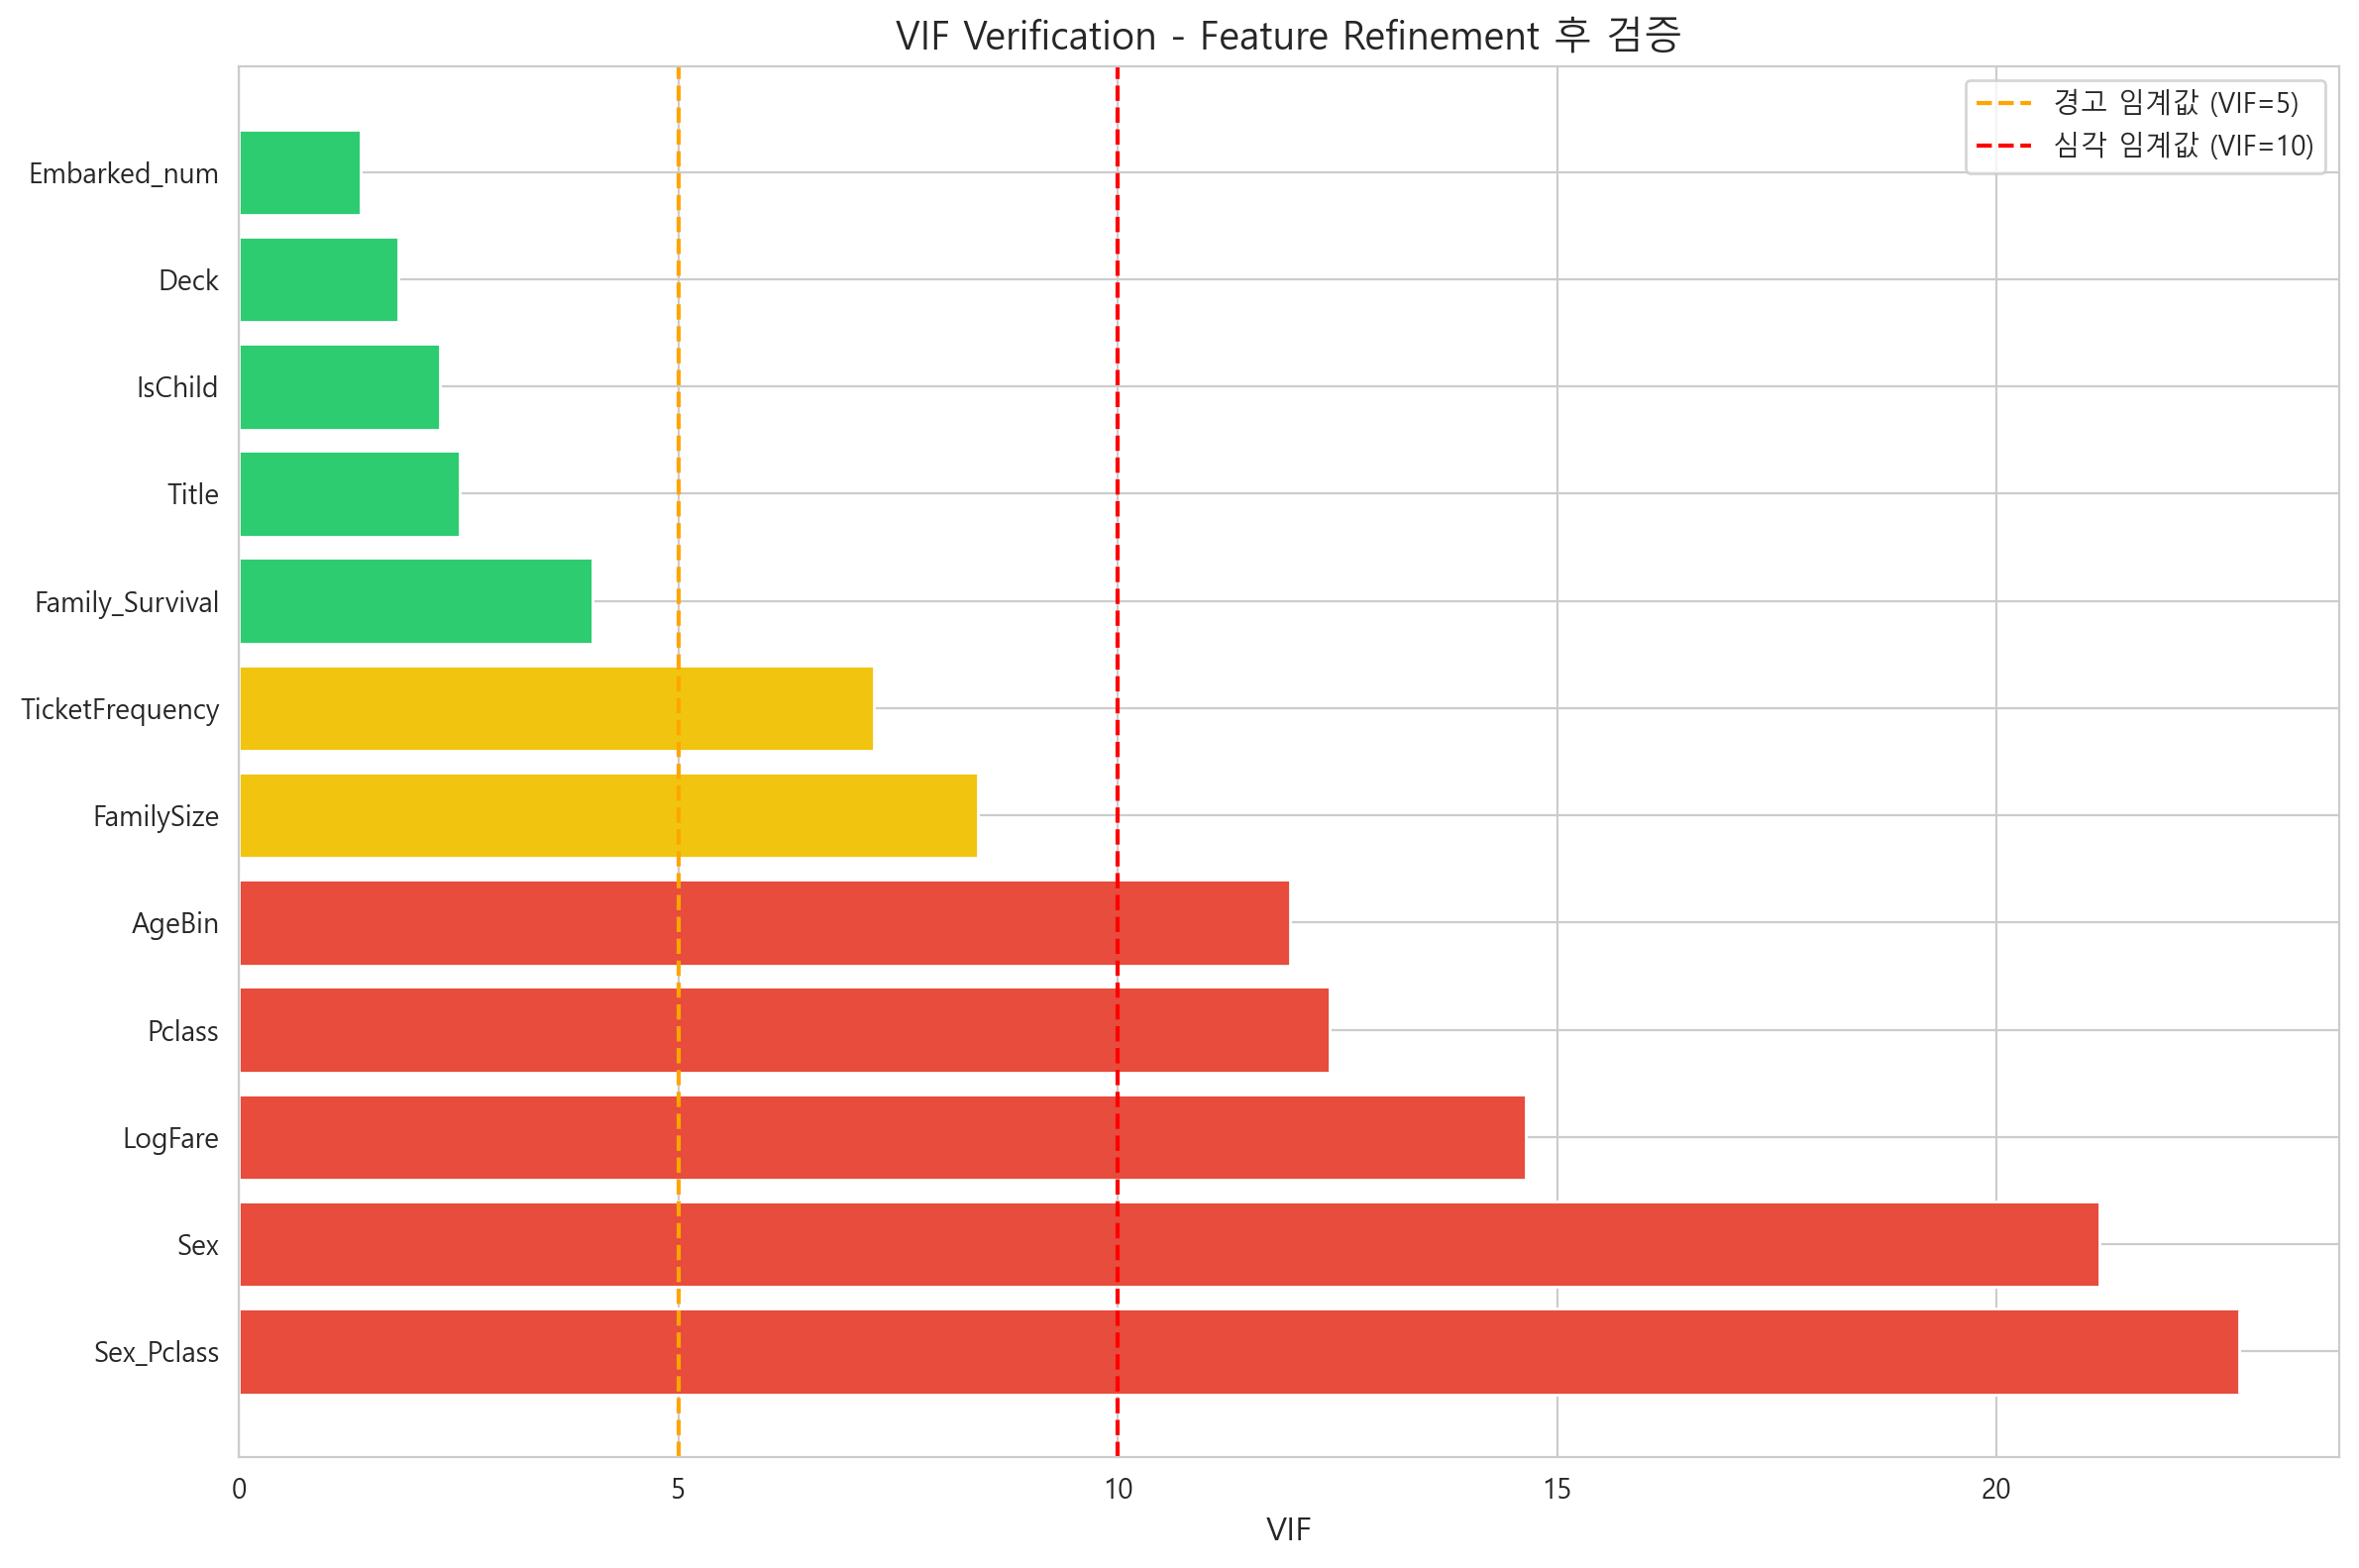


✅ VIF 검증 완료 (Multicollinear Feature 제거됨)


In [10]:
# ============================================================
# 7-4. VIF (Variance Inflation Factor) 검증 (Feature Refinement 후)
# ============================================================
print('📊 VIF (Variance Inflation Factor) 검증')
print('   * 다중공선성 제거 후 남은 Feature들의 VIF 확인')
print('   VIF > 10: 여전히 심각한 다중공선성 존재 가능성\n')

def calculate_vif(X):
    """Calculate VIF for all features"""
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_df = calculate_vif(X_train)
vif_df['Status'] = vif_df['VIF'].apply(
    lambda x: '🚨 주의' if x > 10 else ('⚠️ 경고' if x > 5 else '✅ 정상')
)

print(vif_df.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
colors = ['#e74c3c' if v > 10 else '#f1c40f' if v > 5 else '#2ecc71' for v in vif_df['VIF']]
plt.barh(vif_df['Feature'], vif_df['VIF'], color=colors)
plt.axvline(x=5, color='orange', linestyle='--', label='경고 임계값 (VIF=5)')
plt.axvline(x=10, color='red', linestyle='--', label='심각 임계값 (VIF=10)')
plt.xlabel('VIF')
plt.title('VIF Verification - Feature Refinement 후 검증', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

print('\n✅ VIF 검증 완료 (Multicollinear Feature 제거됨)')

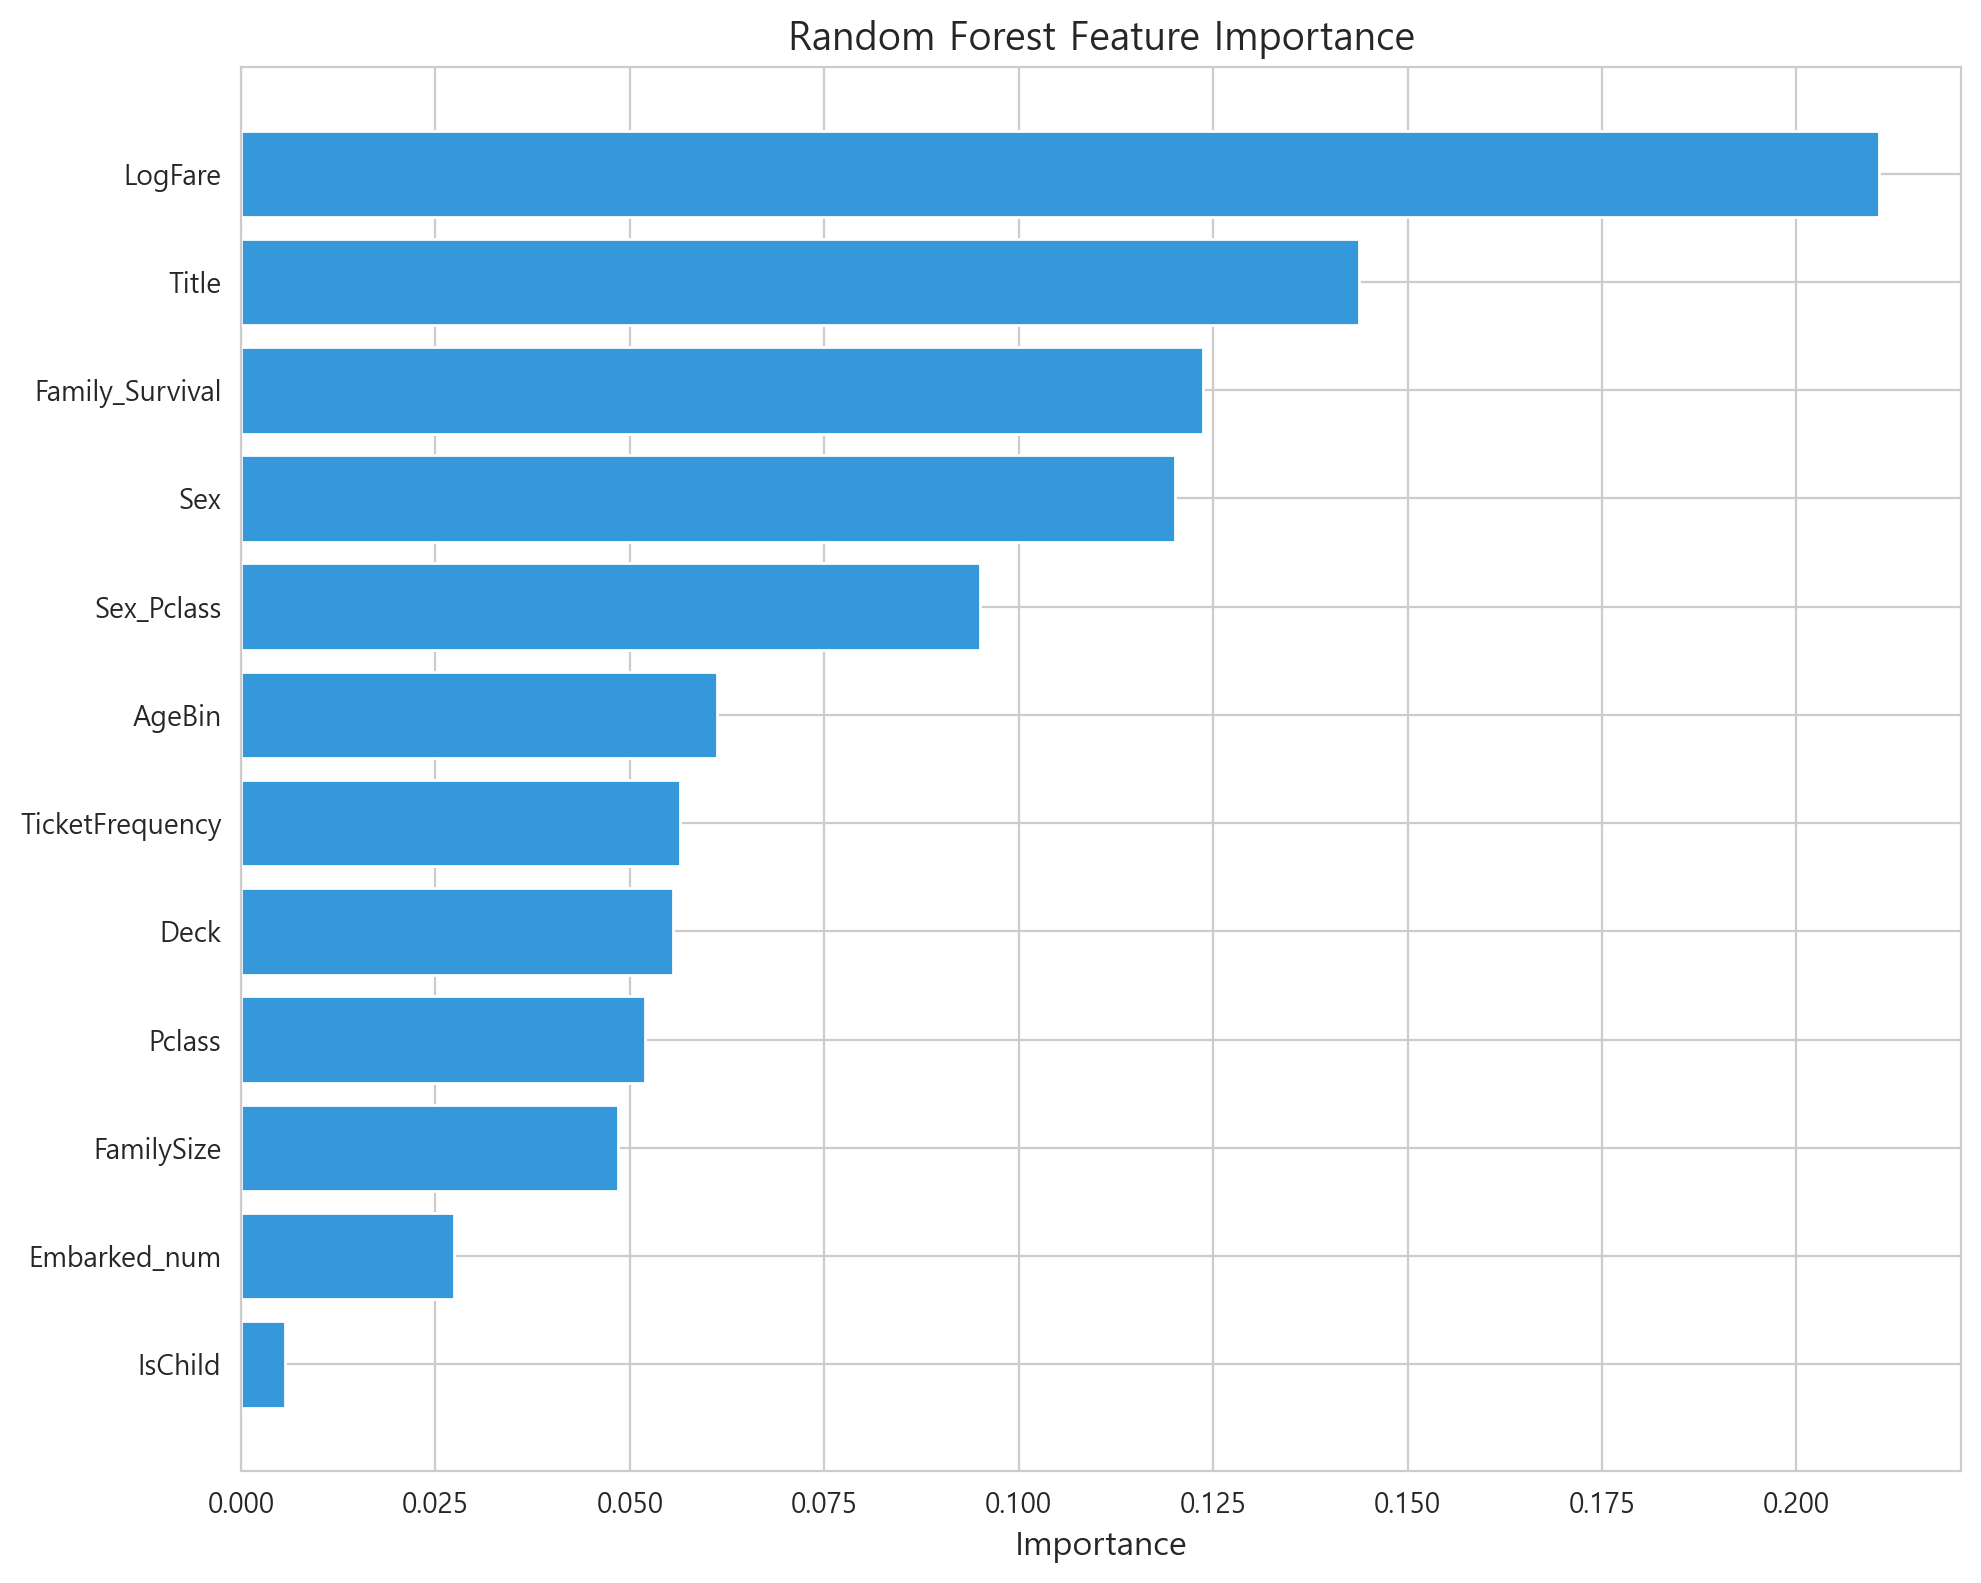


✅ EDA 완료


In [11]:
# ============================================================
# 7-5. Feature Importance
# ============================================================
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#3498db')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()

print('\n✅ EDA 완료')

In [12]:
# ============================================================
# 8. 과적합 검사 함수
# ============================================================

def check_overfitting_with_feedback(model, X_train, y_train, model_name, cv, threshold=0.05):
    model_clone = model.__class__(**model.get_params())
    model_clone.fit(X_train, y_train)
    train_acc = model_clone.score(X_train, y_train)
    cv_scores = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring='accuracy')
    cv_acc = cv_scores.mean()
    gap = train_acc - cv_acc
    is_overfitting = gap > threshold
    
    if gap > 0.10:
        print(f'🚨 {model_name}: 심각한 과적합! Train={train_acc:.4f}, CV={cv_acc:.4f}, Gap={gap:.4f}')
    elif gap > 0.05:
        print(f'⚠️ {model_name}: 과적합 경고. Train={train_acc:.4f}, CV={cv_acc:.4f}, Gap={gap:.4f}')
    else:
        print(f'✅ {model_name}: 정상. Train={train_acc:.4f}, CV={cv_acc:.4f}, Gap={gap:.4f}')
    
    return is_overfitting, gap, train_acc, cv_acc

print('✅ 과적합 감지 함수 정의 완료')

✅ 과적합 감지 함수 정의 완료


In [13]:
# ============================================================
# 9. AdaptiveHyperparams
# ============================================================

class AdaptiveHyperparams:
    def __init__(self):
        self.reset()
    def reset(self):
        self.max_depth_range = (2, 5)
        self.reg_alpha_min = 0.1
        self.reg_lambda_min = 0.1
        self.subsample_range = (0.6, 0.9)
        self.adjustment_count = 0
    def adjust_for_overfitting(self):
        self.adjustment_count += 1
        print(f'\n💊 과적합 조정 #{self.adjustment_count}')
        self.max_depth_range = (2, max(2, self.max_depth_range[1] - 2))
        self.reg_alpha_min = min(max(self.reg_alpha_min * 10, 1.0), 20.0)
        self.reg_lambda_min = min(max(self.reg_lambda_min * 10, 1.0), 20.0)
        self.subsample_range = (max(0.4, self.subsample_range[0] - 0.1), max(0.5, self.subsample_range[1] - 0.2))
        return self.adjustment_count < 3

adaptive_params = AdaptiveHyperparams()
print('✅ AdaptiveHyperparams 정의 완료')

✅ AdaptiveHyperparams 정의 완료


In [14]:
# ============================================================
# 10. Model Comparison
# ============================================================

tree_models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis()
}

scale_models = {
    'SVC': Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True, random_state=42))]),
    'KNeighbors': Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_jobs=-1))]),
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=42))]),
    'MLP': Pipeline([('scaler', StandardScaler()), ('model', MLPClassifier(max_iter=1000, random_state=42))])
}

all_models = {**tree_models, **scale_models}

print('📊 Model Comparison:')
model_scores = {}
for name, model in all_models.items():
    try:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        model_scores[name] = scores.mean()
        print(f'  {name}: {scores.mean():.4f} ± {scores.std():.4f}')
    except Exception as e:
        print(f'  {name}: Error - {e}')

sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
print(f'\n🏆 Top 5:')
for name, score in sorted_models[:5]: print(f'  {name}: {score:.4f}')

📊 Model Comparison:
  GradientBoosting: 0.8672 ± 0.0305
  RandomForest: 0.8446 ± 0.0301
  XGBoost: 0.8532 ± 0.0294
  ExtraTrees: 0.8417 ± 0.0284
  AdaBoost: 0.8549 ± 0.0290
  GaussianNB: 0.7940 ± 0.0347
  LDA: 0.8580 ± 0.0270
  SVC: 0.8597 ± 0.0264
  KNeighbors: 0.8469 ± 0.0265
  LogisticRegression: 0.8548 ± 0.0291
  MLP: 0.8601 ± 0.0292

🏆 Top 5:
  GradientBoosting: 0.8672
  MLP: 0.8601
  SVC: 0.8597
  LDA: 0.8580
  AdaBoost: 0.8549


In [15]:
# ============================================================
# 11. Optuna XGBoost Tuning
# ============================================================

def tune_xgb(X_train, y_train, cv, cv_optuna, adaptive_params, max_iterations=3):
    adaptive_params.reset()
    for iteration in range(max_iterations):
        print(f'\n{"="*50}\n🚀 XGBoost 튜닝 #{iteration + 1}\n{"="*50}')
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 250),
                'max_depth': trial.suggest_int('max_depth', adaptive_params.max_depth_range[0], adaptive_params.max_depth_range[1]),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
                'subsample': trial.suggest_float('subsample', adaptive_params.subsample_range[0], adaptive_params.subsample_range[1]),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
                'reg_alpha': trial.suggest_float('reg_alpha', adaptive_params.reg_alpha_min, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', adaptive_params.reg_lambda_min, 10.0, log=True),
                'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'logloss', 'n_jobs': -1
            }
            return cross_val_score(XGBClassifier(**params), X_train, y_train, cv=cv_optuna, scoring='accuracy').mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42+iteration))
        study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
        print(f'Best CV: {study.best_value:.4f}')
        best_model = XGBClassifier(**study.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
        best_model.fit(X_train, y_train)
        is_overfitting, _, _, _ = check_overfitting_with_feedback(best_model, X_train, y_train, 'XGBoost', cv)
        if not is_overfitting: return study, best_model
        if not adaptive_params.adjust_for_overfitting(): return study, best_model
    return study, best_model

study_xgb, best_xgb = tune_xgb(X_train, y_train, cv, cv_optuna, adaptive_params)


🚀 XGBoost 튜닝 #1


Best trial: 5. Best value: 0.873996: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it, 25.08/90 seconds]


Best CV: 0.8740
✅ XGBoost: 정상. Train=0.8917, CV=0.8730, Gap=0.0186


In [16]:
# ============================================================
# 12. Optuna RandomForest Tuning
# ============================================================

def tune_rf(X_train, y_train, cv, cv_optuna, adaptive_params, max_iterations=3):
    adaptive_params.reset()
    for iteration in range(max_iterations):
        print(f'\n{"="*50}\n🚀 RandomForest 튜닝 #{iteration + 1}\n{"="*50}')
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 250),
                'max_depth': trial.suggest_int('max_depth', adaptive_params.max_depth_range[0], adaptive_params.max_depth_range[1] + 3),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
                'random_state': 42, 'n_jobs': -1
            }
            return cross_val_score(RandomForestClassifier(**params), X_train, y_train, cv=cv_optuna, scoring='accuracy').mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42+iteration))
        study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
        print(f'Best CV: {study.best_value:.4f}')
        best_model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
        best_model.fit(X_train, y_train)
        is_overfitting, _, _, _ = check_overfitting_with_feedback(best_model, X_train, y_train, 'RandomForest', cv)
        if not is_overfitting: return study, best_model
        if not adaptive_params.adjust_for_overfitting(): return study, best_model
    return study, best_model

study_rf, best_rf = tune_rf(X_train, y_train, cv, cv_optuna, adaptive_params)


🚀 RandomForest 튜닝 #1


Best trial: 15. Best value: 0.867135: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, 78.68/90 seconds]


Best CV: 0.8671
✅ RandomForest: 정상. Train=0.8930, CV=0.8649, Gap=0.0281


In [17]:
# ============================================================
# 13. Optuna GradientBoosting Tuning
# ============================================================

def tune_gb(X_train, y_train, cv, cv_optuna, adaptive_params, max_iterations=3):
    adaptive_params.reset()
    for iteration in range(max_iterations):
        print(f'\n{"="*50}\n🚀 GradientBoosting 튜닝 #{iteration + 1}\n{"="*50}')
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 250),
                'max_depth': trial.suggest_int('max_depth', adaptive_params.max_depth_range[0], adaptive_params.max_depth_range[1]),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
                'subsample': trial.suggest_float('subsample', adaptive_params.subsample_range[0], adaptive_params.subsample_range[1]),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                'random_state': 42
            }
            return cross_val_score(GradientBoostingClassifier(**params), X_train, y_train, cv=cv_optuna, scoring='accuracy').mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42+iteration))
        study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
        print(f'Best CV: {study.best_value:.4f}')
        best_model = GradientBoostingClassifier(**study.best_params, random_state=42)
        best_model.fit(X_train, y_train)
        is_overfitting, _, _, _ = check_overfitting_with_feedback(best_model, X_train, y_train, 'GradientBoosting', cv)
        if not is_overfitting: return study, best_model
        if not adaptive_params.adjust_for_overfitting(): return study, best_model
    return study, best_model

study_gb, best_gb = tune_gb(X_train, y_train, cv, cv_optuna, adaptive_params)


🚀 GradientBoosting 튜닝 #1


Best trial: 17. Best value: 0.874272: 100%|██████████| 25/25 [01:01<00:00,  2.47s/it, 61.74/90 seconds]


Best CV: 0.8743
✅ GradientBoosting: 정상. Train=0.9009, CV=0.8721, Gap=0.0288


In [18]:
# ============================================================
# 14. Validation Performance
# ============================================================

tuned_models = {'XGBoost': best_xgb, 'RandomForest': best_rf, 'GradientBoosting': best_gb}

print('📊 Validation Set 성능:')
val_results = {}
for name, model in tuned_models.items():
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_results[name] = val_acc
    print(f'  {name}: {val_acc:.4f}')

📊 Validation Set 성능:
  XGBoost: 0.7687
  RandomForest: 0.7836
  GradientBoosting: 0.7687


In [19]:
# ============================================================
# 15. Ensemble
# ============================================================

estimators = [(name, model) for name, model in tuned_models.items()]

try:
    voting_soft = VotingClassifier(estimators=estimators, voting='soft')
    voting_soft.fit(X_train, y_train)
    voting_soft_acc = accuracy_score(y_val, voting_soft.predict(X_val))
    print(f'Voting (Soft): {voting_soft_acc:.4f}')

    voting_hard = VotingClassifier(estimators=estimators, voting='hard')
    voting_hard.fit(X_train, y_train)
    voting_hard_acc = accuracy_score(y_val, voting_hard.predict(X_val))
    print(f'Voting (Hard): {voting_hard_acc:.4f}')
    
    stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=0.1, max_iter=1000), cv=5, n_jobs=-1)
    stacking.fit(X_train, y_train)
    stacking_acc = accuracy_score(y_val, stacking.predict(X_val))
    print(f'Stacking: {stacking_acc:.4f}')
    print(f'\n🏆 Best Ensemble: {max(voting_soft_acc, voting_hard_acc, stacking_acc):.4f}')
except Exception as e:
    print(f'⚠️ Ensemble Error: {e}')

Voting (Soft): 0.7612
Voting (Hard): 0.7612
Stacking: 0.7612

🏆 Best Ensemble: 0.7612


In [20]:
# ============================================================
# 16. 최종 제출
# ============================================================
import os

X_full = pd.concat([X_train, X_val], ignore_index=True)
y_full = pd.concat([y_train, y_val], ignore_index=True)

output_path = r'C:/Users/user/github/DataScience/scikit-learn/scikit-learn/Submission'
os.makedirs(output_path, exist_ok=True)

voting_soft.fit(X_full, y_full)
voting_hard.fit(X_full, y_full)
stacking.fit(X_full, y_full)

for name, model in [('Pro5_Voting_Soft_WCG', voting_soft), ('Pro5_Voting_Hard_WCG', voting_hard), ('Pro5_Stacking_WCG', stacking)]:
    pred = model.predict(X_test).astype(int)
    pd.DataFrame({'PassengerId': test_passenger_ids, 'Survived': pred}).to_csv(f'{output_path}/submission_{name}.csv', index=False)
    print(f'✅ submission_{name}.csv saved ({pred.sum()}/{len(pred)})')

best_single_name = max(val_results, key=val_results.get)
best_single_model = tuned_models[best_single_name]
best_single_model.fit(X_full, y_full)
pred = best_single_model.predict(X_test).astype(int)
pd.DataFrame({'PassengerId': test_passenger_ids, 'Survived': pred}).to_csv(f'{output_path}/submission_Pro5_{best_single_name}_WCG.csv', index=False)
print(f'✅ submission_Pro5_{best_single_name}_WCG.csv saved ({pred.sum()}/{len(pred)})')

print('\n🎉 Complete!')

✅ submission_Pro5_Voting_Soft_WCG.csv saved (152/418)
✅ submission_Pro5_Voting_Hard_WCG.csv saved (155/418)
✅ submission_Pro5_Stacking_WCG.csv saved (151/418)
✅ submission_Pro5_RandomForest_WCG.csv saved (145/418)

🎉 Complete!
